# MNIST dataset

#### We will now look at the MNIST dataset, which consists of 10 classes of the handwritten numbers 0,1,2,3,4,5,6,7,8, and 9.


## Content
1. Import libraries, load data and basic preprocessing
    * Import libraries
    * Loading and pre-processing data
2. Data visualization
    * Distribution of classes
    * Visualize 10 first samples
3. Modelling
    * Performance
    * Convolutional neural network
    * Training of model
4. Results
    * Visualize performance on the 10 first samples in test set
    * Confusion matrix

# 1. Import libraries, load data and basic preprocessing
## 1.1 Import Libraries

In [1]:
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.datasets import mnist
import pandas as pd

## 1.2 Load and preproces data
#### We get the MNIST dataset from Tensorflow. 

- turn into categorical
- Normalize data
- Make sure that the dataset is the right shape so that it can be put into a CNN

In [2]:
def mnist_dataset(p, categorical = False, CNN = False):
    (X_train,y_train), (X_test, y_test) = mnist.load_data()
    
    # Flatten the images
    image_vector_size = 28*28
    X_train = X_train.reshape(X_train.shape[0], image_vector_size)
    X_test = X_test.reshape(X_test.shape[0], image_vector_size)
    if categorical:
        y_train = np_utils.to_categorical(y_train, num_classes = 10)
        y_test = np_utils.to_categorical(y_test, num_classes = 10)
    
    X_train, X_test = sklearn.preprocessing.normalize(X_train,norm='l2'), sklearn.preprocessing.normalize(X_test,norm='l2')
    
    if CNN:
        X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
        X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
    return X_train,X_test,y_train,y_test

# 2. Data visualization

## 2.1 Ratio of classes
#### From the figure below, we observe that each class contains approximately the same number of images.

11501568/11490434 [==============================] - 0s 0us/step


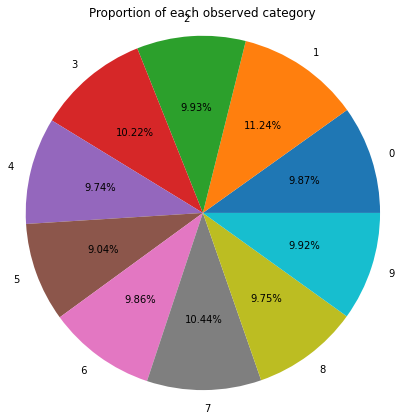

In [3]:
X_train, X_test, y_train, y_test = mnist_dataset(0.25)

label_names = ['0', '1', '2', '3','4',
              '5',' 6', '7', '8', '9']

_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)

plt.figure(figsize = (7,7))
plt.pie(train_counts,
        labels = label_names,
        autopct = '%1.2f%%'
       )
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## 2.2 Visualize samples of dataset
#### We visualize the 10 first samples in the dataset to see how the images look like. We see that the images are of size 28x28.

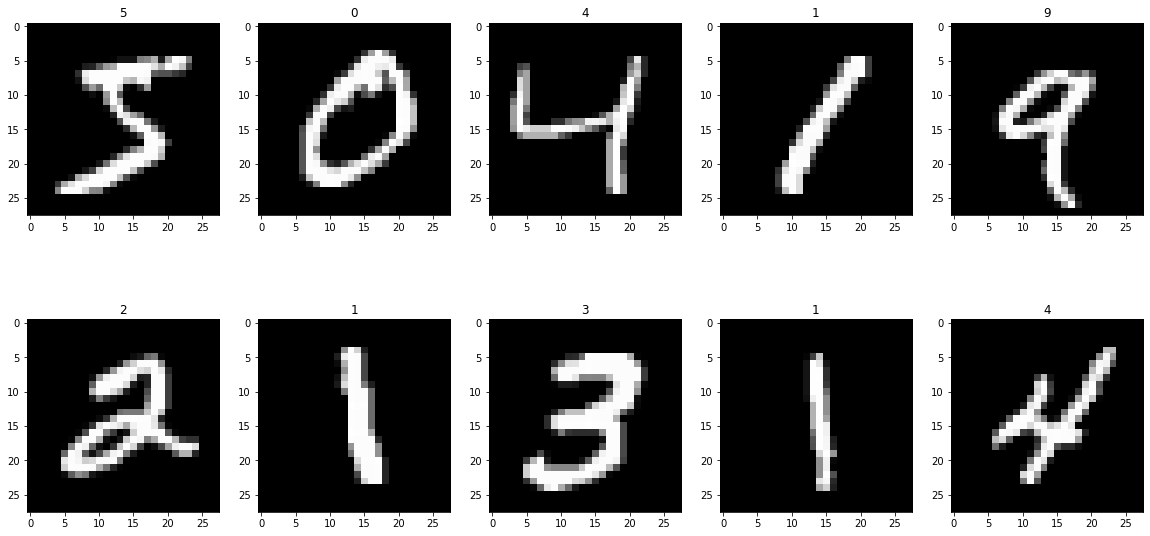

In [4]:
# Load data again, but this time do some pre-processing
X_train, X_test, y_train, y_test = mnist_dataset(0.25, True, True)

sample = [0,1,2,3,4,5,6,7,8,9]
labels = {0: '0', 1: '1',
          2: '2', 3: '3',
          4: '4', 5: '5',
          6: '6', 7: '7',
          8: '8', 9: '9'}

plt.figure(figsize = (20,10))
for i, sampl in enumerate(sample):
    image = X_train[sampl]
    label = np.argmax(y_train[sampl])
    plt.subplot(2,5,i+1)
    plt.imshow(image, cmap='gray')
    plt.title(labels[label])
plt.show()

# 3. Modelling

## 3.1 Performance
### Script for plotting the loss and accuracy of our trained model

In [5]:
def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize = (15,7))
    plt.subplot(1,2,1)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend(prop={'size': 13})
    # plot accuracy
    plt.subplot(1,2,2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend(prop={'size': 13})
    plt.show()

## 3.2 CNN model
#### We use a convolutional neural network, with batch normalization, weight initialization, dropout and the activation function ReLU.

In [6]:
def create_model(model,output1, act_func = 'relu', weight_init = 'he_uniform', dropout = 0, add_batch = None):
    model.add(Conv2D(32, (3, 3), activation = act_func, kernel_initializer = weight_init, 
                     padding='same', input_shape=(28, 28, 1)))
    if add_batch: model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation = act_func, kernel_initializer = weight_init, padding='same'))
    if add_batch: model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    model.add(Conv2D(64, (3, 3), activation = act_func, kernel_initializer = weight_init, padding='same'))
    if add_batch: model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation = act_func, kernel_initializer = weight_init, padding='same'))
    if add_batch: model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    model.add(Conv2D(128, (3, 3), activation = act_func, kernel_initializer =  weight_init, padding='same'))
    if add_batch: model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation = act_func, kernel_initializer = weight_init, padding='same'))
    if add_batch: model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(128, activation = act_func, kernel_initializer = weight_init))
    model.add(Dropout(dropout))
    model.add(Dense(output1, activation='softmax'))

## 3.3 Training of model
#### To train our model, we use Adam optimizer with a learning rate of 0.001. To reduce overfitting, we use early stopping. Early stopping will stop training when the validation loss stops decreasing (with a patience of 3). 

Epoch 1/10
1875/1875 [==============================] - 155s 82ms/step - loss: 0.1778 - accuracy: 0.9452 - val_loss: 0.0569 - val_accuracy: 0.9837
Epoch 2/10
1875/1875 [==============================] - 147s 78ms/step - loss: 0.0653 - accuracy: 0.9810 - val_loss: 0.0357 - val_accuracy: 0.9905
Epoch 3/10
1875/1875 [==============================] - 151s 80ms/step - loss: 0.0536 - accuracy: 0.9848 - val_loss: 0.0362 - val_accuracy: 0.9904
Epoch 4/10
1875/1875 [==============================] - 143s 76ms/step - loss: 0.0455 - accuracy: 0.9872 - val_loss: 0.0344 - val_accuracy: 0.9891
Epoch 5/10
1875/1875 [==============================] - 138s 74ms/step - loss: 0.0375 - accuracy: 0.9889 - val_loss: 0.0220 - val_accuracy: 0.9934
Epoch 6/10
1875/1875 [==============================] - 138s 74ms/step - loss: 0.0344 - accuracy: 0.9898 - val_loss: 0.0413 - val_accuracy: 0.9885
Epoch 7/10
1875/1875 [==============================] - 145s 77ms/step - loss: 0.0303 - accuracy: 0.9912 - val_loss: 0

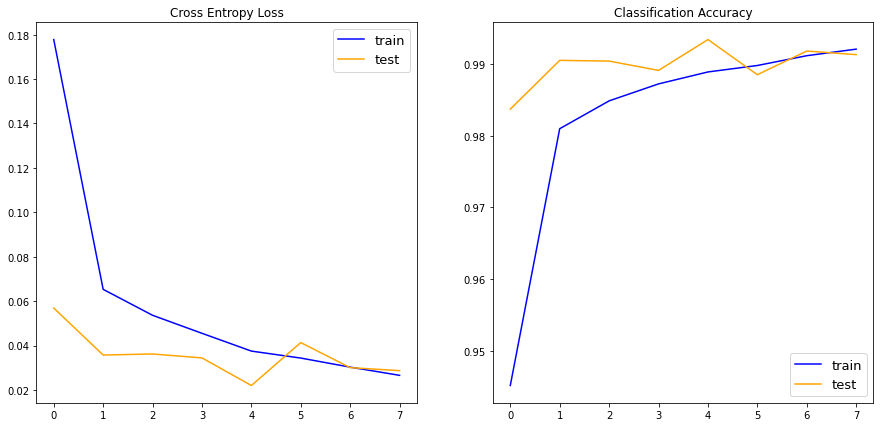

In [7]:
model = Sequential()
create_model(model, 10, 'relu', 'he_uniform', dropout = 0.2, add_batch = True)

from tensorflow.keras.callbacks import EarlyStopping
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs = 10, batch_size=32, 
                    validation_data=(X_test, y_test), verbose = True, callbacks=[es])

summarize_diagnostics(history)

# 4. Results
#### We will now look at how our model performed on the test set.

## 4.1 Testing on test set
#### We now plot the 10 first samples in the test set and see how our model performs on them. We see that it manages to recognize the 10 first samples.

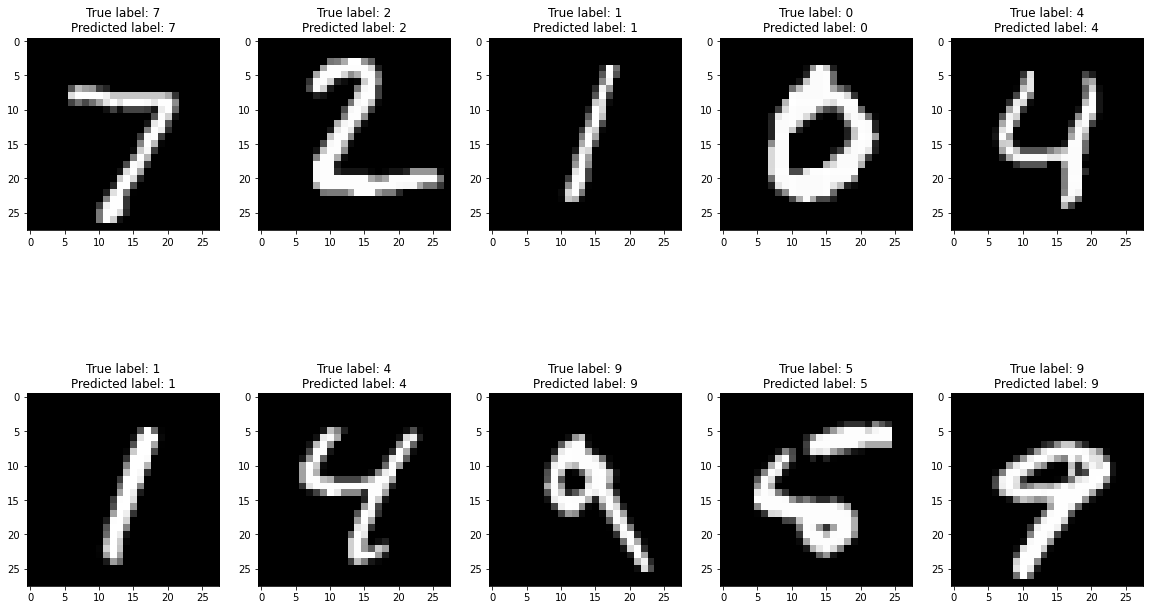

In [8]:
# plot the sample
sample = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize = (20,12))
for i, sampl in enumerate(sample):
    image = X_test[sampl]
    label = np.argmax(y_test[sampl])
    pred = np.argmax(model.predict(image[None,:,:])[0], axis = -1)
    plt.subplot(2,5,i+1)
    plt.imshow(image, cmap='gray')
    plt.title('True label: ' + str(labels[label]) + '\n'
             'Predicted label: ' + str(labels[pred]))
plt.show()

## 4.2 Confusion matrix
#### The confusion matrix allows us to see how the model scores individually on each class. Overall, each class scores very well.

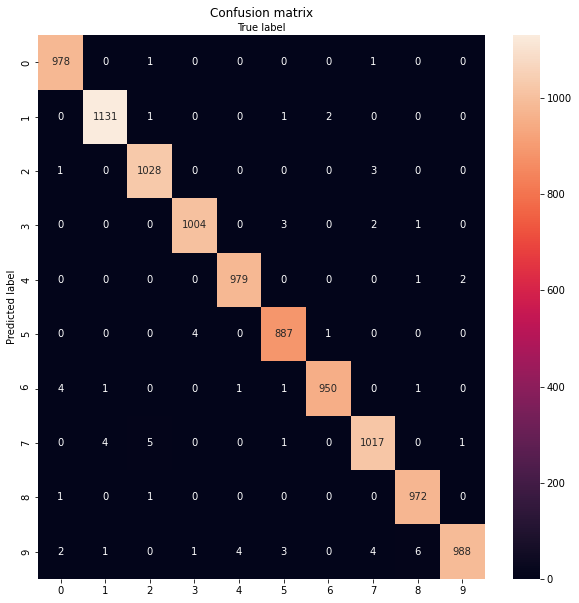

In [9]:
import seaborn as sn
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

CM = confusion_matrix(np.argmax(y_test, axis = 1), pred_labels)
plt.figure(figsize = (10,10))
ax = plt.axes()
sn.heatmap(CM, annot = True,
           annot_kws={"size": 10}, 
           xticklabels=label_names, 
           yticklabels=label_names, ax = ax, fmt='g')
ax.set_title('Confusion matrix')
ax.xaxis.set_label_position('top') 
ax.set_xlabel('True label')
ax.set_ylabel('Predicted label')
plt.show()